In [1]:
#Pre-Process

import sagemaker
import boto3
from sagemaker.session import s3_input, Session
import pandas as pd
import urllib
import numpy as np
import os
import argparse
bucket = 'sgmbankapp3'
def create_bucket(bucket,region):
    my_region=region
    s3 = boto3.resource('s3')
        
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket)
    else:
      s3.create_bucket(Bucket=bucket, CreateBucketConfiguration={ 'LocationConstraint': my_region})
    print('S3: {} bucket created successfully'.format(bucket))
    
    
    
def get_main_data(bucket,prefix):
    s3 = boto3.resource('s3')
    #return s3.Object('sgmbankapp', 'Output/train/train.csv')
    
    urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
    print('Success: downloaded bank_clean.csv.')
    #main_data=pd.read_csv("bank_clean.csv",index_col=False)
    #print(f"\nMain_data size:{main_data.shape}")
    #print(main_data.head())
    #main_data.reset_index(drop=True, inplace=True)
    #main_data.to_csv("bank_clean.csv",index=False)
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'main_data/main_data.csv')).upload_file('bank_clean.csv')
    
    return s3.Object(bucket,'{}/main_data/main_data.csv'.format(prefix))


def do_preprocess(bucket):
       
    s3 = boto3.resource('s3')
    sess = boto3.Session()
    sm = sess.client("sagemaker")
    prefix="demo"
    region=boto3.session.Session().region_name
    
    if s3.Bucket(bucket).creation_date is None:
        create_bucket(bucket,region)
    else :
        print('S3 {} bucket already exist'.format(bucket))     
   
    
    main_dataset = get_main_data(bucket,prefix)    
    main_data = pd.read_csv(main_dataset.get()['Body'])
    
    
    train_data, validation_data, test_data = np.split(main_data.sample(frac=1, random_state=1729), [int(0.7 * len(main_data)), int(0.97 * len(main_data))])
    
    #print(train_data.shape, validation_data.shape, test_data.shape)
    print(f"\nTrain_data size:{train_data.shape}")
    print(f"Validation_data size:{validation_data.shape}")
    print(f"Test_data size:{test_data.shape}")
    
    pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False,header=False)
    
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv') 
    
    pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)
    
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
    
    
    test_data.to_csv("test_actual.csv",index=False)
    test_data.drop(['y_no', 'y_yes'], axis=1).to_csv("test.csv",index=False)
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix,'test/test.csv')).upload_file('test.csv')
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix,
                            'test/test_actual.csv')).upload_file('test_actual.csv')
    
    print("\ncompleted pre-processing")
   
    
        
        
if __name__ == '__main__':
    
    do_preprocess(bucket)

    

S3 sgmbankapp3 bucket already exist
Success: downloaded bank_clean.csv.

Train_data size:(28831, 62)
Validation_data size:(11121, 62)
Test_data size:(1236, 62)

completed pre-processing


In [ ]:
! pip install sagemaker-experiments
! pip -q install sagemaker awscli boto3 smdebug --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
from sagemaker.debugger import rule_configs, Rule, ProfilerRule, DebuggerHookConfig, CollectionConfig
import boto3

bucket="sgmbankapp3"
prefix="data"
s3 = boto3.resource('s3')
sess = boto3.Session()
sm = sess.client("sagemaker")    
region=boto3.Session().region_name
role='arn:aws:iam::499554417458:role/service-role/AmazonSageMaker-ExecutionRole-20210513T122461'


def load_training_data():

    s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix),                       content_type='csv')
    s3_input_validation = sagemaker.TrainingInput(s3_data='s3://{}/{}/validation'.format(bucket, prefix), 
    content_type='csv')

    #train_obj = s3.Object(bucket,'{}/train/train.csv'.format())
    #train_data = pd.read_csv(train_obj.get()['Body'])    
    #validation_obj=s3.Object(bucket,'{}/validation/validation.csv'.format())
    #validation_data = pd.read_csv(validation_obj.get()['Body'])

    s3_data={'train': s3_input_train,'validation': s3_input_validation}
    return s3_data
        

def create_experiment():   

    exp_name=f"bank-sgexp01-{int(time.time())}"
    #sage_experiment= Experiment.load(experiment_name='bank-sgexp01-1622190219',sagemaker_boto_client=sm)    
    print("Creating Experiment..")
    
    return exp_name,Experiment.create(
    experiment_name=exp_name,
    description="Classification using XGBoost",
    sagemaker_boto_client=sm)

    

def set_debugger():
    save_interval = '1'
    debugger_hook_config= DebuggerHookConfig(s3_output_path='s3://{}/{}/debug'.format(bucket, prefix), 
        collection_configs=[CollectionConfig(name="metrics",parameters={"save_interval": save_interval}),
        CollectionConfig(name="feature_importance",parameters={"save_interval": save_interval})],)

    rules=[           
        Rule.sagemaker(rule_configs.overfit(),rule_parameters={"stop_training_on_fire": "True"}),
        #Rule.sagemaker(rule_configs.vanishing_gradient()),
        #Rule.sagemaker(rule_configs.loss_not_decreasing()),
        #Rule.sagemaker(rule_configs.confusion()),    
        #Rule.sagemaker(rule_configs.overtraining()),
        #Rule.sagemaker(rule_configs.all_zero()),
        #Rule.sagemaker(rule_configs.similar_across_runs())
          ]
    return debugger_hook_config,rules

    


In [2]:
#Training pipleine

import sagemaker
import boto3
from sagemaker.session import s3_input, Session
import pandas as pd
import numpy as np
import os
import argparse

import itertools
import re


from wrapper_v2 import TrainComponents

from sagemaker.amazon.amazon_estimator import get_image_uri
from smexperiments.experiment import Experiment
import time
import datetime
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

from sagemaker.analytics import ExperimentAnalytics
from sagemaker import get_execution_role
import time
from time import strftime, gmtime
import json

bucket="sgmbankapp3"
prefix="demo"
s3 = boto3.resource('s3')
sess = boto3.Session()
sm = sess.client("sagemaker")    
region=boto3.Session().region_name
role='arn:aws:iam::499554417458:role/service-role/AmazonSageMaker-ExecutionRole-20210513T122461'
records={}

print("here")

s3_data = load_training_data() #load Training data

print("Training data loaded successfully")

output_path='s3://{}/{}/output'.format(bucket, prefix)   
#file = open(f"records-{datetime.datetime.now():%Y-%m-%d}.txt", "w")  

exp_name, sage_experiment = create_experiment() #create experiment 
print(f"Experiment: {exp_name} is created")
#file.write(f"Experiment: {exp_name}")
#records['Experiment_name']=exp_name

container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='1.0-1')
#container = sagemaker.image_uris.retrieve('xgboost', region, 'latest')


# initialize static hyperparameters (will be same for all trials)
static_hyperparams = {
"min_child_weight":"6",
"subsample":"0.7",
"objective":"binary:logistic",
"num_round":50,
"eval_metric":"error,logloss,auc"
}

#Choosing set of hyperparameters

hyperparam_options = {
'eta': [0.2,0.4],
'gamma':[4],
'max_depth': [5]
}

hypnames, hypvalues = zip(*hyperparam_options.items())
trial_hyperparameter_set = [dict(zip(hypnames, h)) for h in itertools.product(*hypvalues)]

print("Starting training:")

for trial_hyp in trial_hyperparameter_set:

    hyperparams = {**static_hyperparams, **trial_hyp}
    time_append = int(time.time())
    hyp_append = "-".join([str(elm) for elm in trial_hyp.values()])
    job_name = f'xgboost-training-{hyp_append}-{time_append}'
    job_name=re.sub('[^A-Za-z0-9]+', '', job_name)


    trial=f'trial-{hyp_append}-{time_append}'
    trial=re.sub('[^A-Za-z0-9]+', '', trial)

    tf_trial = Trial.create(
        trial_name = trial,
        experiment_name = sage_experiment.experiment_name,
        sagemaker_boto_client = sm)

    time.sleep(2)


    experiment_config = {"ExperimentName"         : sage_experiment.experiment_name,
                       "TrialName"                : tf_trial.trial_name,
                       "TrialComponentDisplayName": job_name}

    #role=sagemaker.get_execution_role()

    debugger_hook_config,rules = set_debugger() #set debugger and rules

    estimator = sagemaker.estimator.Estimator(image_uri=container,
                                      hyperparameters=hyperparams,                                          
                                      role=role,
                                      train_instance_count=1,
                                      train_instance_type='ml.m5.2xlarge',
                                      train_volume_size=5, # 5 GB
                                      output_path=output_path,
                                      train_use_spot_instances=True,
                                      train_max_run=300,
                                      train_max_wait=600,
                                      debugger_hook_config = debugger_hook_config,
                                      rules =rules
                                      )

    estimator.fit(s3_data , job_name = job_name, wait = True, experiment_config = experiment_config)

    time.sleep(3)




ModuleNotFoundError: No module named 'smexperiments'

In [4]:
#Finding best trial

sagemaker_session=Session(sess, sm)

trial_component_analytics = ExperimentAnalytics(sagemaker_session=sagemaker_session,                        
                                                experiment_name=sage_experiment.experiment_name)   

trial_comp_ds = trial_component_analytics.dataframe()

trial_comp_ds.to_csv('experiment_trials.csv')   
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix,                 
'trials/experiment_trials.csv')).upload_file('experiment_trials.csv')

trial_comp_ds.sort_values(['validation:error - Last', 'train:error - Last'], ascending=[True, True],inplace=True)
best_trial_component_name = trial_comp_ds.iloc[0]["TrialComponentName"]
best_trial_component_display_name = trial_comp_ds.iloc[0]["DisplayName"]
print(best_trial_component_name)

xgboosttraining02451626697003-aws-training-job


In [5]:
#Plotting best trial

from smdebug.trials import create_trial

#s3_output_path = estimator.latest_job_debugger_artifacts_path()
s3_output_path = f's3://{bucket}/{prefix}/debug/{best_trial_component_display_name}/debug-output'
trial = create_trial(s3_output_path)

import matplotlib.pyplot as plt
import seaborn as sns
import re


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')
    
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")


[2021-07-19 12:25:49.948 ip-172-16-117-112:17992 INFO s3_trial.py:42] Loading trial debug-output at path s3://sgmbankapp3/demo/debug/xgboosttraining02451626697003/debug-output


[2021-07-19 12:25:53.578 ip-172-16-117-112:17992 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-07-19 12:25:54.604 ip-172-16-117-112:17992 INFO trial.py:210] Loaded all steps


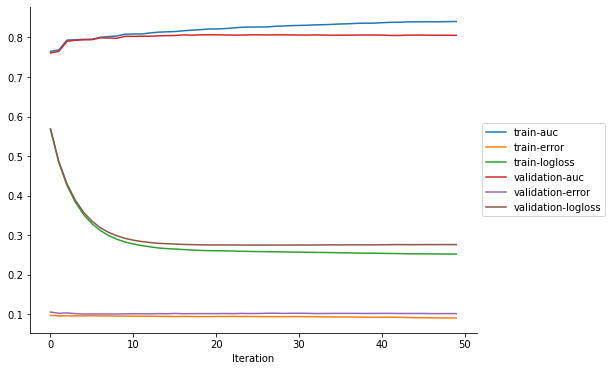

In [6]:
#Training graphs

plot_collection(trial, "metrics")

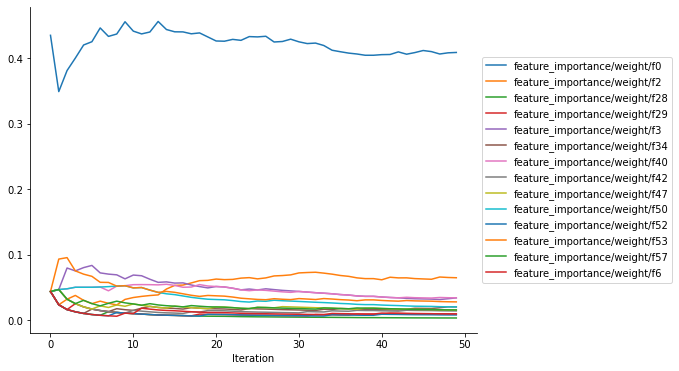

In [7]:
#Feature importance graph

plot_feature_importance(trial)

In [8]:
#creating cloudwatch dashboard

best_trial_component = TrialComponent.load(best_trial_component_name)
best_trial_parameters=best_trial_component.parameters
display_name=best_trial_component.display_name



total_metric=[]
for i in range(0,len(best_trial_component.metrics)):
    total_metric.append(best_trial_component.metrics[i].metric_name)

client = boto3.client('cloudwatch')

properties=""

for i in range(0,len(total_metric)):
    properties +='["/aws/sagemaker/TrainingJobs","'+ total_metric[i] +'","TrainingJobName","'+display_name+'"],'

properties=''.join(properties.rsplit(',', 1))

entries=('SageMaker.ImageUri','SageMaker.InstanceCount','SageMaker.InstanceType','SageMaker.VolumeSizeInGB')
for key in entries:
    if key in best_trial_parameters:
        del best_trial_parameters[key]

parameters=""
for key,value in best_trial_parameters.items():
    parameters+=key+":"+str(value)+",  "


dashboard_body = '{"widgets":[{"type":"metric","x":0,"y":5,"width":14,"height":7,"properties":{"view":"timeSeries","stacked":false,"metrics":['+properties+'],"region": "us-east-1","period":30}},{"type":"metric","x":14,"y":5,"height":7,"properties":{"view":"timeSeries","stacked":false,"metrics":[["/aws/sagemaker/TrainingJobs", "CPUUtilization", "Host", "'+display_name+'/algo-1"],[ ".", "MemoryUtilization", ".", "." ],[ ".", "DiskUtilization", ".", "." ]], "region": "us-east-1"}},{"type":"text","x":0,"y":3,"width":24,"height":1,"properties":{"markdown":"**'+parameters+'**"}}]}'



Thresponse = client.put_dashboard(DashboardName="Bank-demo-dashboard", DashboardBody=dashboard_body)
print("Cloudwatch dashboard created successfully")



Cloudwatch dashboard created successfully


In [9]:
#Creating model registry

model_package_group_name = "xgboost-model-registry"
try :
    sm.create_model_package_group(ModelPackageGroupName=model_package_group_name, 
                                               ModelPackageGroupDescription = "Training using xgboost algorithm")
except Exception as e:
    print (f"{model_package_group_name} already exists")

xgboost-model-registry already exists


In [10]:
#Registering model in model registry

best_trial_component = TrialComponent.load(best_trial_component_name)    
model_data = best_trial_component.output_artifacts["SageMaker.ModelArtifact"].value


create_model_package_input_dict =  { 
        "InferenceSpecification": {    
        "Containers": [ 
         {  
            "Image": container,
            "ModelDataUrl": model_data
         }],
         "SupportedContentTypes": [ "text/csv" ],
         "SupportedResponseMIMETypes": [ "text/csv" ],
         },
    
         "ModelPackageGroupName" : model_package_group_name,
         "ModelPackageDescription" : "XGBoost Model",
         "ModelApprovalStatus" : "Approved"
    
         }


create_mode_package_response = sm.create_model_package(**create_model_package_input_dict)
print(create_mode_package_response)
model_package_arn = create_mode_package_response["ModelPackageArn"]

{'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:499554417458:model-package/xgboost-model-registry/6', 'ResponseMetadata': {'RequestId': '71ff889c-547e-47e8-8a4d-ac924667e98c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '71ff889c-547e-47e8-8a4d-ac924667e98c', 'content-type': 'application/x-amz-json-1.1', 'content-length': '101', 'date': 'Mon, 19 Jul 2021 12:28:04 GMT'}, 'RetryAttempts': 0}}


In [11]:
#Finding second best performing trial

sagemaker_session=Session(sess, sm)

trial_component_analytics = ExperimentAnalytics(sagemaker_session=sagemaker_session,                        
                                                experiment_name=sage_experiment.experiment_name)   

trial_comp_ds = trial_component_analytics.dataframe()

trial_comp_ds.to_csv('experiment_trials.csv')   
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix,                 
'trials/experiment_trials.csv')).upload_file('experiment_trials.csv')

trial_comp_ds.sort_values(['validation:error - Last', 'train:error - Last'], ascending=[True, True],inplace=True)
try:
    s_best_trial_component_name = trial_comp_ds.iloc[1]["TrialComponentName"]
    s_best_trial_component_display_name = trial_comp_ds.iloc[1]["DisplayName"]
    print(s_best_trial_component_name)
except IndexError as e:
    print("Experiment has only one trial")


xgboosttraining04451626697261-aws-training-job


In [12]:
#Adding second best trial model in model registry

s_best_trial_component = TrialComponent.load(s_best_trial_component_name)    
s_model_data = s_best_trial_component.output_artifacts["SageMaker.ModelArtifact"].value


create_model_package_input_dict =  { 
        "InferenceSpecification": {    
        "Containers": [ 
         {  
            "Image": container,
            "ModelDataUrl": s_model_data
         }],
         "SupportedContentTypes": [ "text/csv" ],
         "SupportedResponseMIMETypes": [ "text/csv" ],
         },
    
         "ModelPackageGroupName" : model_package_group_name,
         "ModelPackageDescription" : "XGBoost Model",
         "ModelApprovalStatus" : "Approved"
    
         }


create_mode_package_response = sm.create_model_package(**create_model_package_input_dict)
print(create_mode_package_response)
s_model_package_arn = create_mode_package_response["ModelPackageArn"]

{'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:499554417458:model-package/xgboost-model-registry/7', 'ResponseMetadata': {'RequestId': '2381234d-804e-4cd2-a587-d49e08855178', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2381234d-804e-4cd2-a587-d49e08855178', 'content-type': 'application/x-amz-json-1.1', 'content-length': '101', 'date': 'Mon, 19 Jul 2021 12:28:29 GMT'}, 'RetryAttempts': 0}}


In [13]:
#Displaying model registry

sm.list_model_packages(ModelPackageGroupName=model_package_group_name)

{'ModelPackageSummaryList': [{'ModelPackageGroupName': 'xgboost-model-registry',
   'ModelPackageVersion': 7,
   'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:499554417458:model-package/xgboost-model-registry/7',
   'ModelPackageDescription': 'XGBoost Model',
   'CreationTime': datetime.datetime(2021, 7, 19, 12, 28, 30, 120000, tzinfo=tzlocal()),
   'ModelPackageStatus': 'Completed',
   'ModelApprovalStatus': 'Approved'},
  {'ModelPackageGroupName': 'xgboost-model-registry',
   'ModelPackageVersion': 6,
   'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:499554417458:model-package/xgboost-model-registry/6',
   'ModelPackageDescription': 'XGBoost Model',
   'CreationTime': datetime.datetime(2021, 7, 19, 12, 28, 4, 470000, tzinfo=tzlocal()),
   'ModelPackageStatus': 'Completed',
   'ModelApprovalStatus': 'Approved'},
  {'ModelPackageGroupName': 'xgboost-model-registry',
   'ModelPackageVersion': 5,
   'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:499554417458:model-package/xgboost-mod

In [15]:
#Deplyoing model on sagemaker

model_name_1 = f'xgboost-model-1-{time_append}'
model_name_2 = f'xgboost-model-2-{time_append}'

primary_container_1 = {'ModelPackageName': model_package_arn}
primary_container_2 = {'ModelPackageName': s_model_package_arn}

sm.create_model(ModelName = model_name_1,ExecutionRoleArn = role,PrimaryContainer = primary_container_1)
sm.create_model(ModelName = model_name_2,ExecutionRoleArn = role,PrimaryContainer = primary_container_2)

{'ModelArn': 'arn:aws:sagemaker:us-east-1:499554417458:model/xgboost-model-2-1626697261',
 'ResponseMetadata': {'RequestId': 'ecc37b47-340f-4a0d-be2e-60b9b23a575c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ecc37b47-340f-4a0d-be2e-60b9b23a575c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '88',
   'date': 'Mon, 19 Jul 2021 12:29:23 GMT'},
  'RetryAttempts': 2}}

In [18]:
#Creating variants for endpoints and assigning initial weights

from sagemaker.session import Session, production_variant

variant1 = production_variant(model_name= model_name_1,
                              instance_type="ml.m5.xlarge",
                              initial_instance_count=1,
                              variant_name='Variant1',
                              initial_weight=3)
        
variant2 = production_variant(model_name= model_name_2,
                      instance_type="ml.m5.xlarge",
                      initial_instance_count=1,
                      variant_name='Variant2',
                      initial_weight=1)

print(variant1, variant2)

{'ModelName': 'xgboost-model-1-1626697261', 'InstanceType': 'ml.m5.xlarge', 'InitialInstanceCount': 1, 'VariantName': 'Variant1', 'InitialVariantWeight': 3} {'ModelName': 'xgboost-model-2-1626697261', 'InstanceType': 'ml.m5.xlarge', 'InitialInstanceCount': 1, 'VariantName': 'Variant2', 'InitialVariantWeight': 1}


In [20]:
#Endpoint configurations

from sagemaker.model_monitor.data_capture_config import DataCaptureConfig

capture_path = 's3://{}/{}/capture'.format(bucket,prefix)
data_capture_config = DataCaptureConfig(       
                     enable_capture = True,                     # Capture data
                     sampling_percentage = 100,                 
                     #capture_options = [“REQUEST”, “RESPONSE”] # Default value
                     #model_path = info['ModelArtifacts']['S3ModelArtifacts'],
                     destination_s3_uri = capture_path  , # Save data here
                     capture_options = ["Output","Input"]
                     )

In [21]:
#Creating endpoint

sm_session = Session(sess)
endpoint_name="xgboost-demo-endpoint"
sm_session.endpoint_from_production_variants(name=endpoint_name, production_variants=[variant1, variant2],
                        data_capture_config_dict = data_capture_config._to_request_dict())

INFO:sagemaker:Creating endpoint with name xgboost-demo-endpoint


---------------!

'xgboost-demo-endpoint'

In [44]:
#Prediction using csv file stored in s3

import csv

s3_resource = sess.resource('s3')
sm_runtime = sess.client("sagemaker-runtime")
s3_object = s3_resource.Object(bucket,f'{prefix}/test/test.csv')

data = s3_object.get()['Body'].read().decode('utf-8').splitlines()

lines_all = csv.reader(data)

headers = next(lines_all)
i=0

result=[]

for line in lines_all:
    payload_for = ','.join(line)
    if(i>100):
        break
    response1 = sm_runtime.invoke_endpoint(EndpointName=endpoint_name, 
                          ContentType='text/csv', 
                          Body=payload_for)

    result1 = response1['Body'].read().decode()
    result.append(result1)
    i=i+1
    #print(payload_for)
    time.sleep(0.2)

print(result)

['0.2520415484905243', '0.042635396122932434', '0.020852822810411453', '0.03009958565235138', '0.03863244503736496', '0.06587056070566177', '0.023775378242135048', '0.73871248960495', '0.09507742524147034', '0.055065177381038666', '0.03573131561279297', '0.0518876276910305', '0.07573545724153519', '0.03402120620012283', '0.03112412430346012', '0.025310218334197998', '0.03017491102218628', '0.02656635455787182', '0.07465837895870209', '0.023220300674438477', '0.06094733625650406', '0.04149586707353592', '0.10193148255348206', '0.06581664830446243', '0.08942922204732895', '0.04343686252832413', '0.36119991540908813', '0.5301201939582825', '0.5455881357192993', '0.049899522215127945', '0.789662778377533', '0.3120669722557068', '0.3221648037433624', '0.1105663850903511', '0.14976748824119568', '0.06793598085641861', '0.06808757036924362', '0.052029095590114594', '0.018386267125606537', '0.03641827404499054', '0.05677075684070587', '0.046216171234846115', '0.03875833377242088', '0.052609518

In [29]:
#Getting cloudwatch invocation metrics

import pandas as pd
from datetime import datetime, timedelta

cw = boto3.Session().client("cloudwatch")


def get_invocation_metrics_for_endpoint_variant(endpoint_name, variant_name, start_time, end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
    )
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop("Unit", axis=1)
        .rename(columns={"Sum": variant_name})
    )


def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, "Variant1", start_time, end_time
    )
    metrics_variant2 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, "Variant2", start_time, end_time
    )
    metrics_variants = metrics_variant1.join(metrics_variant2, how="outer")
    metrics_variants.plot()
    return metrics_variants

Waiting a minute for initial metric creation...


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Variant1,Variant2
Timestamp,,
2021-07-19 12:38:00+00:00,0.0,0.0
2021-07-19 12:39:00+00:00,0.0,0.0
2021-07-19 12:40:00+00:00,0.0,0.0
2021-07-19 12:41:00+00:00,2.0,NaN
2021-07-19 12:42:00+00:00,89.0,27.0
2021-07-19 12:43:00+00:00,80.0,37.0
2021-07-19 12:44:00+00:00,90.0,28.0
2021-07-19 12:45:00+00:00,88.0,28.0
2021-07-19 12:46:00+00:00,75.0,41.0


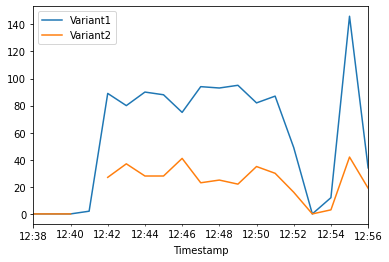

In [30]:
#AB testing

print("Waiting a minute for initial metric creation...")
time.sleep(60)
plot_endpoint_metrics()

In [32]:
#Creating baseline data using training file
#Creating monitoring schedule to check data drift

from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor import EndpointInput
from sagemaker.model_monitor.dataset_format import DatasetFormat


from sagemaker.model_monitor import CronExpressionGenerator
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat



baseline_data_uri = 's3://{}/{}/train/train.csv'.format(bucket, prefix)  
        
baseline_results_uri = 's3://{}/{}/baseline'.format(bucket, prefix)

#s3_code_postprocessor_uri = 's3://{}/{}/code/postprocessor.py'.format(self.bucket, self.prefix)

s3_report_path = 's3://{}/{}/report'.format(bucket, prefix)

constaints_file_path = '{}/baseline/constraints.json'.format(prefix)



#creating baseline data

sm_session = Session(sess)
my_default_monitor = DefaultModelMonitor(role=role,instance_count=1,instance_type='ml.m5.xlarge',
                                         volume_size_in_gb=20, max_runtime_in_seconds=3600,sagemaker_session=sm_session)

my_default_monitor.suggest_baseline(baseline_dataset=baseline_data_uri,
                                    dataset_format=DatasetFormat.csv(header=False),
                                    output_s3_uri=baseline_results_uri,
                                    wait=True)



s3.Bucket('sgmbankapp3').download_file(constaints_file_path, os.path.join(os.getcwd(),'constraints.json'))


with open('constraints.json') as f:
    data = f.read()
d = json.loads(data)

d["features"][0]["inferred_type"]="Fractional"
d["monitoring_config"]["distribution_constraints"]["comparison_threshold"]=0.3


with open('constraints.json', 'w') as f:
    f.write(json.dumps(d,indent=2))

s3.Bucket(bucket).Object(constaints_file_path).upload_file('constraints.json')

#os.remove(os.path.join(os.getcwd(),'constraints.json'))                                           



monitor_schedule_name = f'monitor-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())       


my_default_monitor.create_monitoring_schedule(monitor_schedule_name = monitor_schedule_name, 
endpoint_input= endpoint_name,
#post_analytics_processor_script=s3_code_postprocessor_uri,
output_s3_uri=s3_report_path,
statistics=f'{baseline_results_uri}/statistics.json',
constraints=f'{baseline_results_uri}/constraints.json',                                             
#statistics=my_default_monitor.baseline_statistics(),
#constraints=my_default_monitor.suggested_constraints(),
schedule_cron_expression=CronExpressionGenerator.hourly(),
enable_cloudwatch_metrics=True)  


print(f'{mon_schedule_name} created successfully')
    

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating processing-job with name baseline-suggestion-job-2021-07-19-12-59-27-279



Job Name:  baseline-suggestion-job-2021-07-19-12-59-27-279
Inputs:  [{'InputName': 'baseline_dataset_input', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sgmbankapp3/demo/train/train.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sgmbankapp3/demo/baseline', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.........................2021-07-19 13:03:20,489 - __main__ - INFO - All params:{'ProcessingJobArn': 'arn:aws:sagemaker:us-east-1:499554417458:processing-job/baseline-suggestion-job-2021-07-19-12-59-27-279', 'ProcessingJobName': 'baseline-suggestion-job-2021-07-19-12-59-27-279', 'Environment': {'dataset_format': '{"csv": {"header": false, "output_columns_position": "START"}}', 'dataset_source': '/opt/ml/processing/inpu

In [3]:
#Creating cloudwatch alarm for data drift
import boto3
def create_cloudwatch_alarm(endpoint_name,monitor_schedule_name):
            
    cw_client = boto3.Session().client("cloudwatch")

    alarm_name = "DEMO_XGBOOST_DATA_QUALITY_USING_C1_Feature"
    alarm_desc = (
    "Trigger an CloudWatch alarm when the c1 score drifts away from the baseline constraints"
    )
    mdoel_quality_f2_drift_threshold = (
    0.3  ##Setting this threshold purposefully low to see the alarm quickly.
    )
    metric_name = "feature_baseline_drift__c1"
    namespace = "aws/sagemaker/Endpoints/data-metrics"
    endpoint_name = endpoint_name
    monitor_schedule_name = monitor_schedule_name

    cw_client.put_metric_alarm(AlarmName=alarm_name,
                               AlarmDescription=alarm_desc,
                               ActionsEnabled=True,
                               MetricName=metric_name,
                               Namespace=namespace,
                               Statistic="Average",
                               Dimensions=[
    {"Name": "Endpoint", "Value": endpoint_name},
    {"Name": "MonitoringSchedule", "Value": monitor_schedule_name},
                               ],
                               Period=3600,
                               EvaluationPeriods=3,
                               DatapointsToAlarm=3,
                               Threshold=mdoel_quality_f2_drift_threshold,
                               ComparisonOperator="GreaterThanOrEqualToThreshold",
                               TreatMissingData="notBreaching",
                           )

    print("Cloudwatch alarm created for data drift")


create_cloudwatch_alarm(endpoint_name,monitor_schedule_name)


Cloudwatch alarm created for data drift


In [2]:
print('test')

test
